In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cp /content/drive/MyDrive/100k.zip /content/100k.zip
!unzip -q 100k.zip


Mounted at /content/drive


# Import dependecies

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sb
import pickle


from PIL import Image
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, models
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, fbeta_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#  Data preprocessing

### Dataset class

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=20000, seed=42):
        self.root_dir = Path(root_dir)

        self.target_size = target_size  # Target size for pairs
        self.seed = seed  # Seed for reproducibility

        self.image_pairs = []
        self.labels = []

        # Determine whether grayscale is used based on the transform pipeline
        self.transform = transform

        #self.grayscale = any(isinstance(t, transforms.Grayscale) for t in self.transform.transforms)
        self.grayscale = False

        # Collect image pairs
        self._collect_image_pairs()

    def _collect_image_pairs(self):
        positive_pairs = []
        negative_pairs = []

        # Set the random seed for reproducibility
        random.seed(self.seed)

        # Navigate through the folders and collect image pairs
        for subdir in ['0', '1']:
            class_folder = self.root_dir / subdir
            for subfolder in class_folder.iterdir():
                image_files = list(subfolder.glob('*'))  # Collect all image files in the subfolder
                if len(image_files) == 2:  # Ensure there are exactly two images
                    if subdir == '1':
                        positive_pairs.append((image_files[0], image_files[1]))
                    else:
                        negative_pairs.append((image_files[0], image_files[1]))

        # Shuffle and limit to target size
        random.shuffle(positive_pairs)
        random.shuffle(negative_pairs)
        positive_pairs = positive_pairs[:self.target_size // 2]
        negative_pairs = negative_pairs[:self.target_size // 2]

        self.image_pairs = positive_pairs + negative_pairs
        self.labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

        # Shuffle the pairs and labels together
        combined = list(zip(self.image_pairs, self.labels))
        random.shuffle(combined)
        self.image_pairs[:], self.labels[:] = zip(*combined)

    def __getitem__(self, index):
        img1_path, img2_path = self.image_pairs[index]
        img1 = Image.open(img1_path).convert('RGB')  # Always open in RGB
        img2 = Image.open(img2_path).convert('RGB')  # Always open in RGB

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(self.labels[index], dtype=torch.float32)

    def __len__(self):
        return len(self.image_pairs)

    def plot_random_image_pair(self, seed=42):
        if seed is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            np.random.seed(seed)

        # Select a random index and use __getitem__ to fetch the images
        idx = random.randint(0, len(self) - 1)
        img1, img2, label = self[idx]

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        if self.grayscale:
            img1 = img1.squeeze(0).numpy()
            img2 = img2.squeeze(0).numpy()
            axs[0].imshow(img1, cmap='gray')
            axs[1].imshow(img2, cmap='gray')
        else:
            # Convert back to numpy array for plotting without normalization
            img1 = img1.permute(1, 2, 0).numpy()
            img2 = img2.permute(1, 2, 0).numpy()
            img1 = (img1 - img1.min()) / (img1.max() - img1.min())
            img2 = (img2 - img2.min()) / (img2.max() - img2.min())
            axs[0].imshow(img1)
            axs[1].imshow(img2)

        axs[0].set_title('Image 1')
        axs[0].axis('off')

        axs[1].set_title('Image 2')
        axs[1].axis('off')

        plt.suptitle(f'Label: {label.item()}')
        plt.show()

#### Mean and Std calc

In [ ]:
# import torch
# from torchvision import transforms
# from tqdm import tqdm  # For displaying progress bar

# # Initialize variables to compute mean and std
# n_images = 0
# mean_sum = torch.zeros(1) if dataset.grayscale else torch.zeros(3)
# std_sum = torch.zeros(1) if dataset.grayscale else torch.zeros(3)

# # Iterate over all images in the dataset
# for i in tqdm(range(len(dataset))):
#     img1, img2, label = dataset[i]  # Get image pair and label

#     # Accumulate mean and std for both images in the pair
#     n_images += 1
#     mean_sum += img1.mean(dim=(1, 2))
#     std_sum += img1.std(dim=(1, 2))

#     n_images += 1
#     mean_sum += img2.mean(dim=(1, 2))
#     std_sum += img2.std(dim=(1, 2))

# # Compute the mean and standard deviation
# mean = mean_sum / n_images
# std = std_sum / n_images

# print("Mean:", mean)
# print("Standard Deviation:", std)

#### K-fold Cross-Validation helper fun

In [ ]:
from collections import Counter
def show_kf(kf, dataset):
    for fold, (train_idx, val_idx) in enumerate(kf.split(np.zeros(len(dataset.labels)), dataset.labels)):
        train_labels = np.array([dataset.labels[i] for i in train_idx])
        val_labels = np.array([dataset.labels[i] for i in val_idx])

        train_counter = Counter(train_labels)
        val_counter = Counter(val_labels)

        print(f'Fold {fold + 1}')
        print(f'Training set: {{0: {train_counter[0]}, 1: {train_counter[1]}}}')
        print(f'Validation set: {{0: {val_counter[0]}, 1: {val_counter[1]}}}')

# Models

### Baseline

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=10),
            nn.BatchNorm2d(64),  # Batch normalization for convolutional layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=7),
            nn.BatchNorm2d(128),  # Batch normalization for convolutional layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 128, kernel_size=4),
            nn.BatchNorm2d(128),  # Batch normalization for convolutional layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=4),
            nn.BatchNorm2d(256),  # Batch normalization for convolutional layer
            nn.ReLU(inplace=True)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256*8*8, 4096),
            nn.BatchNorm1d(4096),  # Batch normalization for fully connected layer
            nn.ReLU(inplace=True)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward_one(self, x):
        x = self.cnn1(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        abs_diff = torch.abs(output1 - output2)
        similarity_score = self.fc2(abs_diff)
        return similarity_score

#### Dummy for shapes

In [ ]:
# Instantiate the model
model = SiameseNetwork()

# Create a dummy input tensor with the same dimensions as your actual input (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 124, 124)

# Pass the dummy input through the network and print the output size at each stage
def print_layer_shapes(model, dummy_input):
    x = dummy_input
    for layer in model.cnn1:
        x = layer(x)
        print(f'After layer {layer.__class__.__name__}: {x.shape}')
    x = x.view(x.size()[0], -1)
    print(f'Flattened size: {x.shape}')

print_layer_shapes(model, dummy_input)

After layer Conv2d: torch.Size([1, 64, 115, 115])
After layer BatchNorm2d: torch.Size([1, 64, 115, 115])
After layer ReLU: torch.Size([1, 64, 115, 115])
After layer MaxPool2d: torch.Size([1, 64, 57, 57])
After layer Conv2d: torch.Size([1, 128, 51, 51])
After layer BatchNorm2d: torch.Size([1, 128, 51, 51])
After layer ReLU: torch.Size([1, 128, 51, 51])
After layer MaxPool2d: torch.Size([1, 128, 25, 25])
After layer Conv2d: torch.Size([1, 128, 22, 22])
After layer BatchNorm2d: torch.Size([1, 128, 22, 22])
After layer ReLU: torch.Size([1, 128, 22, 22])
After layer MaxPool2d: torch.Size([1, 128, 11, 11])
After layer Conv2d: torch.Size([1, 256, 8, 8])
After layer BatchNorm2d: torch.Size([1, 256, 8, 8])
After layer ReLU: torch.Size([1, 256, 8, 8])
Flattened size: torch.Size([1, 16384])


### Euclides distance based model

In [ ]:
class Euclides(nn.Module):
    def __init__(self):
        super(Euclides, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=10),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 128)  # Final embedding size remains 128
        )

    def forward_one(self, x):
        x = self.cnn1(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=3.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * 0.5 * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * 0.5 * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

### ResNet18

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()


        weights = models.ResNet18_Weights.DEFAULT
        self.resnet = models.resnet18(weights=weights)

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()


        for param in self.resnet.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(num_ftrs, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward_one(self, x):
        x = self.resnet(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        abs_diff = torch.abs(output1 - output2)
        similarity_score = self.fc2(abs_diff)
        return similarity_score

# Init helper functions



### Train & validate functions

In [ ]:
# Training function
def train_one_epoch(model, train_loader, criterion, optimizer):

    model.train()
    running_train_loss = 0.0

    with tqdm(total=len(train_loader), desc="Training", unit="batch", leave=False) as pbar:
        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            if isinstance(model, Euclides):
              output1, output2 = model(img1, img2)

              loss = criterion(output1, output2, label)

            else:
              similarity_score = model(img1, img2)

              loss = criterion(similarity_score, label.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            pbar.set_postfix({'train_loss': running_train_loss / (pbar.n + 1)})
            pbar.update(1)

    train_loss = running_train_loss / len(train_loader)

    return train_loss

# Validation function
def validate_one_epoch(model, val_loader, criterion):

    model.eval()
    running_val_loss = 0.0

    all_labels = []
    all_outputs = []

    with tqdm(total=len(val_loader), desc="Validation", unit="batch", leave=False) as pbar:
      with torch.inference_mode():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)


            if isinstance(model, Euclides):
              output1, output2 = model(img1, img2)

              loss = criterion(output1, output2, label)
            else:
              similarity_score = model(img1, img2)

              loss = criterion(similarity_score, label.unsqueeze(1))

            running_val_loss += loss.item()

            all_labels.extend(label.cpu().numpy())

            if isinstance(model, Euclides):
              all_outputs.extend(F.pairwise_distance(output1, output2).cpu().numpy())
            else:
              all_outputs.extend(torch.sigmoid(similarity_score).cpu().numpy())

            pbar.update(1)

    val_loss = running_val_loss / len(val_loader)

    return val_loss, np.array(all_outputs), np.array(all_labels)

def calculate_metrics(outputs, labels, threshold=0.6):

    if isinstance(model, Euclides):
      threshold = 2.0
      preds = (outputs < threshold).astype(int)
    else:
      preds = (outputs > threshold).astype(int)

    accuracy = accuracy_score(labels, preds)

    precision = precision_score(labels, preds)

    recall = recall_score(labels, preds)

    f1 = f1_score(labels, preds)

    return accuracy, precision, recall, f1, preds

# Cross-validate model

### Init parameters

In [ ]:
# Hyperparameters
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Define euclides model
model_choice = 'resnet' # ['base', 'euclides, 'resnet']

#### Dataset and transforms

In [ ]:
seed_20k = 777

torch.manual_seed(seed_20k)
np.random.seed(seed_20k)
random.seed(seed_20k)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_20k)
    torch.cuda.manual_seed_all(seed_20k)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

root_dir = "./data"

transform_grayscale = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((124, 124)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4438], std=[0.2419]),
])

transform_rgb = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),
    transforms.Resize((124, 124)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4411, 0.4411, 0.4411], std=[0.2432, 0.2432, 0.2432]),
    transforms.Normalize(mean=[0.5052, 0.4244, 0.3822], std=[0.2623, 0.2415, 0.2376]),
])

weights = models.ResNet18_Weights.DEFAULT
transform_resnet = weights.transforms()

match model_choice:
  case 'base':
    tsm = transform_rgb
  case 'euclides':
    tsm = transform_rgb
  case 'resnet':
    tsm = transform_resnet

# Dataset & DataLoader
dataset = SiameseNetworkDataset(root_dir=root_dir, transform=tsm, seed=seed_20k)

#### KF CV split

In [ ]:
kf_seed = 777

# K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kf_seed)

show_kf(kf, dataset)

Fold 1
Training set: {0: 8000, 1: 8000}
Validation set: {0: 2000, 1: 2000}
Fold 2
Training set: {0: 8000, 1: 8000}
Validation set: {0: 2000, 1: 2000}
Fold 3
Training set: {0: 8000, 1: 8000}
Validation set: {0: 2000, 1: 2000}
Fold 4
Training set: {0: 8000, 1: 8000}
Validation set: {0: 2000, 1: 2000}
Fold 5
Training set: {0: 8000, 1: 8000}
Validation set: {0: 2000, 1: 2000}


### Cross-validate

In [ ]:
fold_metrics = {
    'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
    'train_loss': [], 'val_loss': [],
    'labels': [], 'predictions': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(np.zeros(len(dataset.labels)), dataset.labels)):

    print(f'Fold {fold+1}')
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    match model_choice:
      case 'euclides':
        model = Euclides().to(device)
        criterion = ContrastiveLoss()

      case 'base':
        model = SiameseNetwork().to(device)
        criterion = nn.BCELoss()

      case 'resnet':
        model = ResNet().to(device)
        criterion = nn.BCELoss()

      case _:
        raise ValueError("Invalid model choice.")

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):

        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_outputs, val_labels = validate_one_epoch(model, val_loader, criterion)

        accuracy, precision, recall, f1, preds = calculate_metrics(val_outputs, val_labels)

        fold_metrics['train_loss'].append(train_loss)
        fold_metrics['val_loss'].append(val_loss)
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)

        fold_metrics['labels'].append(val_labels)
        fold_metrics['predictions'].append(preds)

        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')


Fold 1


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.9MB/s]


Epoch [1/5], Train Loss: 0.6516, Val Loss: 0.6060, Accuracy: 0.6717, Precision: 0.6263, Recall: 0.8515, F1: 0.7218


KeyboardInterrupt: 

In [ ]:
# Calculate average metrics
avg_metrics = {metric: np.mean(values) for metric, values in fold_metrics.items()}
std_metrics = {metric: np.std(values) for metric, values in fold_metrics.items()}

# Create a DataFrame for average and standard deviation metrics
metrics_df = pd.DataFrame({
    'Metric': list(avg_metrics.keys()),
    'Average': list(avg_metrics.values()),
    'Standard Deviation': list(std_metrics.values())
})

# Print the DataFrame
metrics_df.transpose()

In [ ]:
# Plot learning curves
epochs = range(1, EPOCHS + 1)
avg_train_losses = np.mean(np.array(fold_metrics['train_loss']).reshape(-1, EPOCHS), axis=0)
avg_val_losses = np.mean(np.array(fold_metrics['val_loss']).reshape(-1, EPOCHS), axis=0)
std_train_losses = np.std(np.array(fold_metrics['train_loss']).reshape(-1, EPOCHS), axis=0)
std_val_losses = np.std(np.array(fold_metrics['val_loss']).reshape(-1, EPOCHS), axis=0)

plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_losses, label='Average Training Loss')
plt.fill_between(epochs, avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.2)
plt.plot(epochs, avg_val_losses, label='Average Validation Loss')
plt.fill_between(epochs, avg_val_losses - std_val_losses, avg_val_losses + std_val_losses, alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss with Std Dev Across Folds')
plt.legend()
plt.show()

In [ ]:
import pickle

with open(f'fold_metrics_{model_choice}.pkl', 'wb') as file:
    pickle.dump(fold_metrics, file)

In [ ]:
# import pickle
# # Specify the model choice used during saving
# model_choice = 'euclides'  # or 'base_siamese', 'resnet_siamese', 'svm', 'cnn'

# # Load the fold_metrics dictionary
# with open(f'/content/fold_metrics.pkl', 'rb') as file:
#     loaded_fold_metrics = pickle.load(file)

# # Verify the loaded data
# print(loaded_fold_metrics)

# Evaluation

## Metrics

### Load metrics from files

In [2]:
# Load the metrics
with open('fold_metrics_base.pkl', 'rb') as file:
    fold_metrics_base = pickle.load(file)

with open('fold_metrics_euclides.pkl', 'rb') as file:
    fold_metrics_euclides = pickle.load(file)

with open('fold_metrics_resnet.pkl', 'rb') as file:
    fold_metrics_resnet = pickle.load(file)

with open('fold_metrics_cnn.pkl', 'rb') as file:
    fold_metrics_cnn = pickle.load(file)

### Helper functions for averaging metrics

In [3]:
def calculate_average_metrics(fold_metrics, model_name):
    avg_metrics = {
        'Accuracy': np.mean(fold_metrics['accuracy']),
        'Precision': np.mean(fold_metrics['precision']),
        'Recall': np.mean(fold_metrics['recall']),
        'F1 Score': np.mean(fold_metrics['f1'])
    }
    return avg_metrics

# Highlight the best value
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

### Prepare metrics and dataframe

In [4]:
avg_metrics_base = calculate_average_metrics(fold_metrics_base, 'Base')
avg_metrics_euclides = calculate_average_metrics(fold_metrics_euclides, 'Euclides')
avg_metrics_resnet = calculate_average_metrics(fold_metrics_resnet, 'ResNet')
avg_metrics_cnn = calculate_average_metrics(fold_metrics_cnn, 'CNN')

# Create DataFrame
metrics_df = pd.DataFrame([avg_metrics_base, avg_metrics_euclides, avg_metrics_resnet, avg_metrics_cnn])

metrics_df = pd.DataFrame({
    'Base': avg_metrics_base,
    'Euclides': avg_metrics_euclides,
    'ResNet': avg_metrics_resnet,
    'CNN': avg_metrics_cnn
})

metrics_df = metrics_df.transpose()

styled_metrics_df = metrics_df.style.apply(highlight_max, axis=0)


### Averaged metrics per model

In [5]:
styled_metrics_df

,Accuracy,Precision,Recall,F1 Score
Base,0.726870,0.694116,0.815460,0.749017
Euclides,0.697870,0.644808,0.899020,0.749417
ResNet,0.720640,0.672479,0.867020,0.756515
CNN,0.663130,0.705804,0.578120,0.628061


## Learning curves

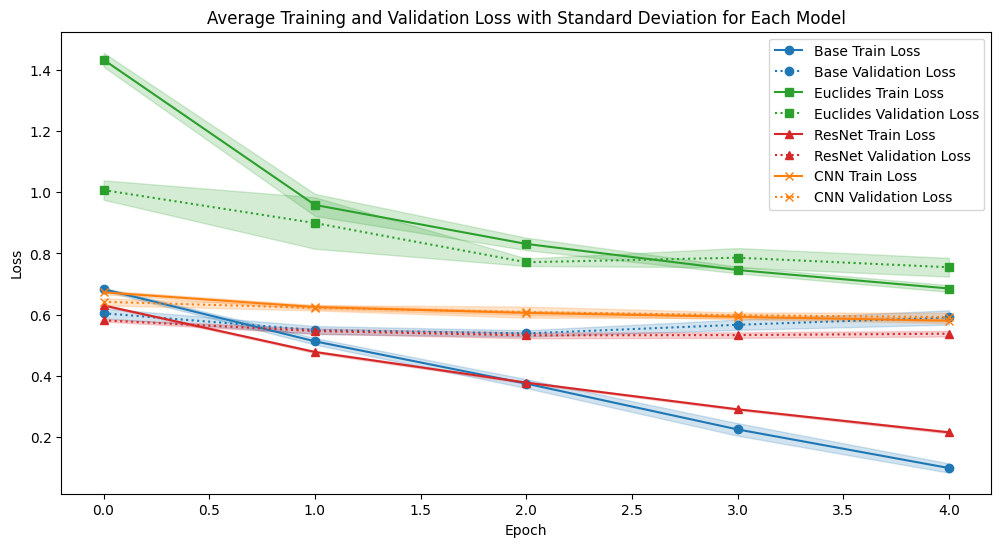

In [16]:
# Plot train and validation loss with standard deviation
def plot_loss_with_std(fold_metrics, model_name, color, marker):
    epochs = range(len(fold_metrics['train_loss']) // 5)  # assuming 5 folds
    train_loss = np.array(fold_metrics['train_loss']).reshape(5, -1)
    val_loss = np.array(fold_metrics['val_loss']).reshape(5, -1)

    train_loss_mean = train_loss.mean(axis=0)
    train_loss_std = train_loss.std(axis=0)
    val_loss_mean = val_loss.mean(axis=0)
    val_loss_std = val_loss.std(axis=0)

    # plt.errorbar(epochs, train_loss_mean, yerr=train_loss_std, label=f'{model_name} Train Loss', color=color, marker=marker, capsize=3)
    # plt.errorbar(epochs, val_loss_mean, yerr=val_loss_std, label=f'{model_name} Validation Loss', color=color, linestyle='dotted', marker=marker, capsize=3)


    plt.plot(epochs, train_loss_mean, label=f'{model_name} Train Loss', color=color, marker=marker)
    plt.fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.2, color=color)
    plt.plot(epochs, val_loss_mean, label=f'{model_name} Validation Loss', color=color, linestyle='dotted', marker=marker)
    plt.fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.2, color=color)


plt.figure(figsize=(12, 6))
plot_loss_with_std(fold_metrics_base, 'Base', '#1f77b4', 'o')
plot_loss_with_std(fold_metrics_euclides, 'Euclides', '#2ca02c', 's')
plot_loss_with_std(fold_metrics_resnet, 'ResNet', '#d62728', '^')
plot_loss_with_std(fold_metrics_cnn, 'CNN', '#ff7f0e', 'x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss with Standard Deviation for Each Model')
plt.legend()
plt.show()

## F-beta Scores

In [13]:
# Function to calculate F-beta score
def calculate_fbeta(y_true, y_pred, betas=[0.25, 0.5, 1, 2, 4, 8]):
    fbeta_scores = {}
    for beta in betas:
        score = fbeta_score(y_true, y_pred, beta=beta)
        fbeta_scores[f'F-beta = {beta}'] = score
    return fbeta_scores

# Calculate F-beta scores for each model
def extract_all_labels_predictions(fold_metrics):
    all_labels = []
    all_predictions = []
    for fold_labels, fold_preds in zip(fold_metrics['labels'], fold_metrics['predictions']):
        all_labels.extend(fold_labels)
        all_predictions.extend(fold_preds)
    return np.array(all_labels), np.array(all_predictions)

labels_base, preds_base = extract_all_labels_predictions(fold_metrics_base)
labels_euclides, preds_euclides = extract_all_labels_predictions(fold_metrics_euclides)
labels_resnet, preds_resnet = extract_all_labels_predictions(fold_metrics_resnet)
labels_cnn, preds_cnn = extract_all_labels_predictions(fold_metrics_cnn)

fbeta_base = calculate_fbeta(labels_base, preds_base)
fbeta_euclides = calculate_fbeta(labels_euclides, preds_euclides)
fbeta_resnet = calculate_fbeta(labels_resnet, preds_resnet)
fbeta_cnn = calculate_fbeta(labels_cnn, preds_cnn)

# Create DataFrame for F-beta scores
fbeta_df = pd.DataFrame({
    'Base': fbeta_base,
    'Euclides': fbeta_euclides,
    'ResNet': fbeta_resnet,
    'CNN': fbeta_cnn
})

# Transpose the DataFrame for better readability
fbeta_df = fbeta_df.transpose()


styled_fbeta_df = fbeta_df.style.apply(highlight_max, axis=0)

In [14]:
styled_fbeta_df

,F-beta = 0.25,F-beta = 0.5,F-beta = 1,F-beta = 2,F-beta = 4,F-beta = 8
Base,0.698911,0.714223,0.749097,0.787552,0.807049,0.813243
Euclides,0.652109,0.680128,0.748466,0.832072,0.878237,0.893490
ResNet,0.679728,0.702491,0.756311,0.819062,0.852342,0.863132
CNN,0.688254,0.669133,0.631832,0.598470,0.583960,0.579636


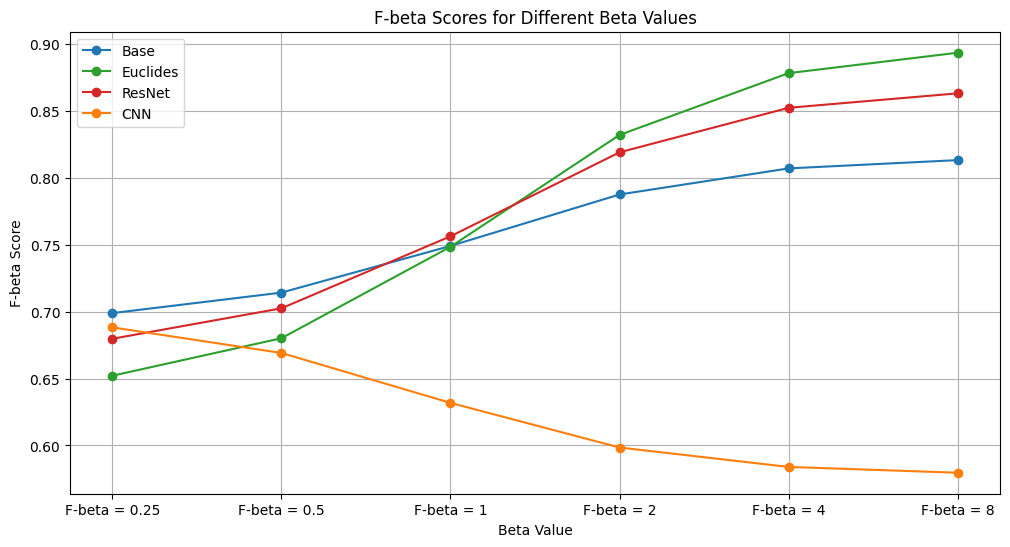

In [19]:
# Plotting F-beta scores
def plot_fbeta(fbeta_df):
    plt.figure(figsize=(12, 6))

    colors = {
        'Base': '#1f77b4',
        'Euclides': '#2ca02c',
        'ResNet': '#d62728',
        'CNN': '#ff7f0e'
    }

    for model in fbeta_df.index:
        plt.plot(fbeta_df.columns, fbeta_df.loc[model], marker='o',color=colors[model], label=model)
    plt.xlabel('Beta Value')
    plt.ylabel('F-beta Score')
    plt.title('F-beta Scores for Different Beta Values')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_fbeta(fbeta_df)

# Statistical tests

## Load tested metrics

In [47]:
model_metrics = {
    'Base': fold_metrics_base,
    'CNN': fold_metrics_cnn,
    'Euclides': fold_metrics_euclides,
    'ResNet': fold_metrics_resnet
}

# Define the metrics to test
metrics_to_test = ['accuracy', 'recall']

## T-test and Wilcoxon test

### Preparation for t-test and Wilcoxon test

In [58]:
from scipy.stats import ttest_rel, wilcoxon

# Initialize lists to hold the results
ttest_results_list = []
wilcoxon_results_list = []

# Helper functions to perform tests and return results in dictionaries
def perform_ttest(metric1, metric2, metric_name, model1, model2):
    ttest_result = ttest_rel(metric1, metric2)
    return {
        'Metric': metric_name,
        'Model Comparison': f'{model1} vs {model2}',
        'T-test Statistic': ttest_result.statistic,
        'T-test p-value': ttest_result.pvalue
    }

def perform_wilcoxon(metric1, metric2, metric_name, model1, model2):
    diff = [m1 - m2 for m1, m2 in zip(metric1, metric2)]
    wilcoxon_result = wilcoxon(diff)
    return {
        'Metric': metric_name,
        'Model Comparison': f'{model1} vs {model2}',
        'Wilcoxon Statistic': wilcoxon_result.statistic,
        'Wilcoxon p-value': wilcoxon_result.pvalue
    }

# Generate pairs of models and perform tests for each metric
model_names = list(model_metrics.keys())
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        model1 = model_names[i]
        model2 = model_names[j]
        for metric_name in metrics_to_test:
            metric1 = model_metrics[model1][metric_name]
            metric2 = model_metrics[model2][metric_name]
            ttest_results_list.append(perform_ttest(metric1, metric2, metric_name, model1, model2))
            wilcoxon_results_list.append(perform_wilcoxon(metric1, metric2, metric_name, model1, model2))

# Convert lists to DataFrames
ttest_results_df = pd.DataFrame(ttest_results_list)
wilcoxon_results_df = pd.DataFrame(wilcoxon_results_list)

# Sort the results by Metric to ensure accuracy results come before recall results
ttest_results_df = ttest_results_df.sort_values(by=['Metric', 'Model Comparison']).reset_index(drop=True)
wilcoxon_results_df = wilcoxon_results_df.sort_values(by=['Metric', 'Model Comparison']).reset_index(drop=True)

# Aggregate the dataframes into one
aggregated_results_df = pd.merge(ttest_results_df, wilcoxon_results_df, on=['Metric', 'Model Comparison'])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


### Show results of tests

In [59]:
aggregated_results_df


,Metric,Model Comparison,T-test Statistic,T-test p-value,Wilcoxon Statistic,Wilcoxon p-value
0,accuracy,Base vs CNN,16.049036,2.469353e-14,0.0,5.960464e-08
1,accuracy,Base vs Euclides,4.460318,1.638422e-04,28.0,8.803606e-05
2,accuracy,Base vs ResNet,2.091463,4.724641e-02,74.0,1.597297e-02
3,accuracy,CNN vs Euclides,-4.010770,5.127606e-04,46.0,1.027107e-03
4,accuracy,CNN vs ResNet,-16.249842,1.877080e-14,0.0,5.960464e-08
5,accuracy,Euclides vs ResNet,-2.981165,6.489468e-03,65.0,7.370949e-03
6,recall,Base vs CNN,10.703570,1.281783e-10,0.0,5.960464e-08
7,recall,Base vs Euclides,-6.870228,4.180342e-07,9.0,1.966953e-06
8,recall,Base vs ResNet,-4.200819,3.168460e-04,32.0,1.623034e-04
9,recall,CNN vs Euclides,-16.239846,1.902753e-14,0.0,5.960464e-08


#### Splitted results

In [60]:
ttest_results_df

,Metric,Model Comparison,T-test Statistic,T-test p-value
0,accuracy,Base vs CNN,16.049036,2.469353e-14
1,accuracy,Base vs Euclides,4.460318,1.638422e-04
2,accuracy,Base vs ResNet,2.091463,4.724641e-02
3,accuracy,CNN vs Euclides,-4.010770,5.127606e-04
4,accuracy,CNN vs ResNet,-16.249842,1.877080e-14
5,accuracy,Euclides vs ResNet,-2.981165,6.489468e-03
6,recall,Base vs CNN,10.703570,1.281783e-10
7,recall,Base vs Euclides,-6.870228,4.180342e-07
8,recall,Base vs ResNet,-4.200819,3.168460e-04
9,recall,CNN vs Euclides,-16.239846,1.902753e-14


In [61]:
wilcoxon_results_df

,Metric,Model Comparison,Wilcoxon Statistic,Wilcoxon p-value
0,accuracy,Base vs CNN,0.0,5.960464e-08
1,accuracy,Base vs Euclides,28.0,8.803606e-05
2,accuracy,Base vs ResNet,74.0,1.597297e-02
3,accuracy,CNN vs Euclides,46.0,1.027107e-03
4,accuracy,CNN vs ResNet,0.0,5.960464e-08
5,accuracy,Euclides vs ResNet,65.0,7.370949e-03
6,recall,Base vs CNN,0.0,5.960464e-08
7,recall,Base vs Euclides,9.0,1.966953e-06
8,recall,Base vs ResNet,32.0,1.623034e-04
9,recall,CNN vs Euclides,0.0,5.960464e-08


## ANOVA and Friedman's test

### Preparation for ANOVA and Friedman's test

In [63]:
from scipy.stats import f_oneway, friedmanchisquare

# Initialize lists to hold the results
anova_results_list = []
friedman_results_list = []

# Helper functions to perform tests and return results in dictionaries
def perform_anova(metrics, metric_name):
    anova_result = f_oneway(*metrics)
    return {
        'Metric': metric_name,
        'Test': 'ANOVA',
        'Statistic': anova_result.statistic,
        'p-value': anova_result.pvalue
    }

def perform_friedman(metrics, metric_name):
    friedman_result = friedmanchisquare(*metrics)
    return {
        'Metric': metric_name,
        'Test': 'Friedman',
        'Statistic': friedman_result.statistic,
        'p-value': friedman_result.pvalue
    }

# Perform ANOVA and Friedman test for each metric
for metric_name in metrics_to_test:
    metrics = [model_metrics[model][metric_name] for model in model_metrics]
    anova_results_list.append(perform_anova(metrics, metric_name))
    friedman_results_list.append(perform_friedman(metrics, metric_name))

# Convert lists to DataFrames
anova_results_df = pd.DataFrame(anova_results_list)
friedman_results_df = pd.DataFrame(friedman_results_list)

# Sort the results by Metric to ensure accuracy results come before recall results
anova_results_df = anova_results_df.sort_values(by=['Metric', 'Test']).reset_index(drop=True)
friedman_results_df = friedman_results_df.sort_values(by=['Metric', 'Test']).reset_index(drop=True)

# Aggregate the dataframes into one
aggregated_results_df = pd.concat([anova_results_df, friedman_results_df], ignore_index=True)

### Show results of tests


In [64]:
aggregated_results_df

,Metric,Test,Statistic,p-value
0,accuracy,ANOVA,17.731133,3.085513e-09
1,recall,ANOVA,144.478792,1.819438e-35
2,accuracy,Friedman,47.736000,2.423540e-10
3,recall,Friedman,61.313253,3.080570e-13


## MacNemar test

### Preparation for MacNemar test

In [66]:
from statsmodels.stats.contingency_tables import mcnemar

# Prepare contingency table for McNemar test
def prepare_mcnemar_table(labels, preds1, preds2):
    contingency_table = np.zeros((2, 2), dtype=int)
    for l, p1, p2 in zip(labels, preds1, preds2):
        if p1 == p2:
            if p1 == l:
                contingency_table[0, 0] += 1
            else:
                contingency_table[1, 1] += 1
        else:
            if p1 == l:
                contingency_table[0, 1] += 1
            else:
                contingency_table[1, 0] += 1
    return contingency_table

# Initialize list to hold the results
mcnemar_results_list = []

# Helper function to perform McNemar's test and return results in a dictionary
def perform_mcnemar(labels, preds1, preds2, model1, model2):
    contingency_table = prepare_mcnemar_table(labels, preds1, preds2)
    mcnemar_result = mcnemar(contingency_table)
    return {
        'Model Comparison': f'{model1} vs {model2}',
        'McNemar Statistic': mcnemar_result.statistic,
        'McNemar p-value': mcnemar_result.pvalue
    }

# Dictionary to map model names to their corresponding labels and predictions
model_data = {
    'Base': (labels_base, preds_base),
    'CNN': (labels_cnn, preds_cnn),
    'Euclides': (labels_euclides, preds_euclides),
    'ResNet': (labels_resnet, preds_resnet)
}

# Generate pairs of models and perform McNemar's test
model_names = list(model_data.keys())

for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        model1 = model_names[i]
        model2 = model_names[j]
        labels1, preds1 = model_data[model1]
        labels2, preds2 = model_data[model2]
        # Use the labels of the first model in the pair
        mcnemar_results_list.append(perform_mcnemar(labels1, preds1, preds2, model1, model2))

# Convert list to DataFrame
mcnemar_results_df = pd.DataFrame(mcnemar_results_list)

# Sort the results by Model Comparison
mcnemar_results_df = mcnemar_results_df.sort_values(by=['Model Comparison']).reset_index(drop=True)

### Show results of tests

In [67]:
mcnemar_results_df

,Model Comparison,McNemar Statistic,McNemar p-value
0,Base vs CNN,18945.0,3.013962e-202
1,Base vs Euclides,10430.0,4.237065e-79
2,Base vs ResNet,13684.0,2.008854e-04
3,CNN vs Euclides,21638.0,4.147278e-58
4,CNN vs ResNet,19923.0,3.954926e-160
5,Euclides vs ResNet,11699.0,7.556379e-46
